In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import*
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import cv2
from mpl_toolkits.axes_grid import ImageGrid
plt.style.use('dark_background')


In [ ]:
data_path = '/content/drive/My Drive/lgg-mri-segmentation/kaggle_3m/'

In [ ]:
#raw data
import os
import glob
df_img = []
for sub_dir in glob.glob(data_path+"*"):
  if os.path.isdir(sub_dir):
    dir = sub_dir.split('/')[-1]
    for filename in os.listdir(sub_dir):
      img_path = sub_dir+ '/' + filename
      df_img.extend([dir,img_path])
  else:
    print('This is not a dir:', sub_dir)

This is not a dir: /content/drive/My Drive/lgg-mri-segmentation/kaggle_3m/README.md
This is not a dir: /content/drive/My Drive/lgg-mri-segmentation/kaggle_3m/data.csv


In [ ]:
df = pd.DataFrame({'dirname':df_img[::2],'path':df_img[1::2]})
df.head(5)

,dirname,path
0,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...
1,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...
2,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...
3,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...
4,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...


In [ ]:
df_notmask = df[~df['path'].str.contains("mask")]
df_masks = df[df['path'].str.contains("mask")]
img = df_notmask['path'].values 
masks = df_masks['path'].values

In [ ]:
#final dataframe
df = pd.DataFrame({'patient': df_notmask.dirname.values, 'image_path':img, 'mask_path':masks})

def category(mask_path):
  value = np.max(cv2.imread(mask_path))
  if value > 0 : return 1
  else : return 0

df['diagnosis'] = df['mask_path'].apply(lambda m:category(m))
df.head()


,patient,image_path,mask_path,diagnosis
0,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...,/content/drive/My Drive/lgg-mri-segmentation/k...,0
1,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...,/content/drive/My Drive/lgg-mri-segmentation/k...,1
2,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...,/content/drive/My Drive/lgg-mri-segmentation/k...,1
3,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...,/content/drive/My Drive/lgg-mri-segmentation/k...,1
4,TCGA_CS_4941_19960909,/content/drive/My Drive/lgg-mri-segmentation/k...,/content/drive/My Drive/lgg-mri-segmentation/k...,1


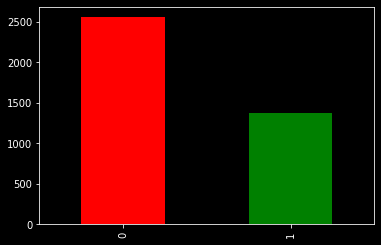

In [ ]:
#distribution
ax = df.diagnosis.value_counts().plot(kind='bar',stacked=True,color=['red','green'])

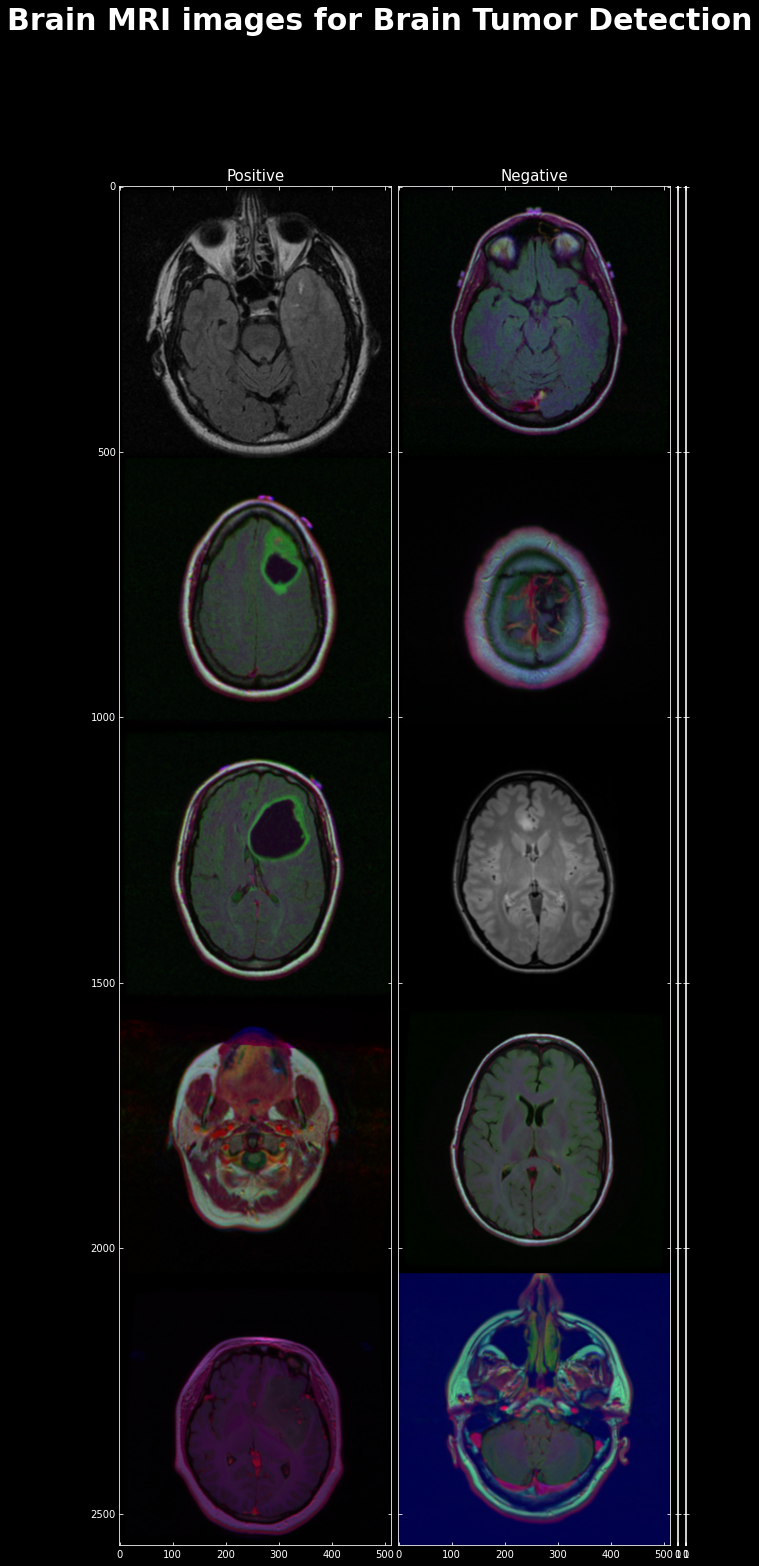

In [ ]:
#img viz
sample_pos = df[df['diagnosis'] == 1].sample(5).image_path.values
sample_neg = df[df['diagnosis'] == 0].sample(5).image_path.values
sample_img =[]

for i, (yes,no) in enumerate(zip(sample_pos,sample_neg)):
  yes = cv2.resize(cv2.imread(yes),(512,512))
  no = cv2.resize(cv2.imread(no),(512,512))
  sample_img.extend([yes,no])

sample_pos_arr = np.vstack(np.array(sample_img[::2]))
sample_neg_arr = np.vstack(np.array(sample_img[1::2]))

fig = plt.figure(figsize=(25.,25.))
grid = ImageGrid(fig, 111, nrows_ncols=(1,4),axes_pad=0.1)

grid[0].imshow(sample_pos_arr)
grid[0].set_title('Positive',fontsize=15)
grid[0].axis('off')
grid[1].imshow(sample_neg_arr)
grid[1].set_title('Negative',fontsize=15)
grid[1].axis('off')

plt.suptitle("Brain MRI images for Brain Tumor Detection", fontsize=30,weight='bold')
plt.show()

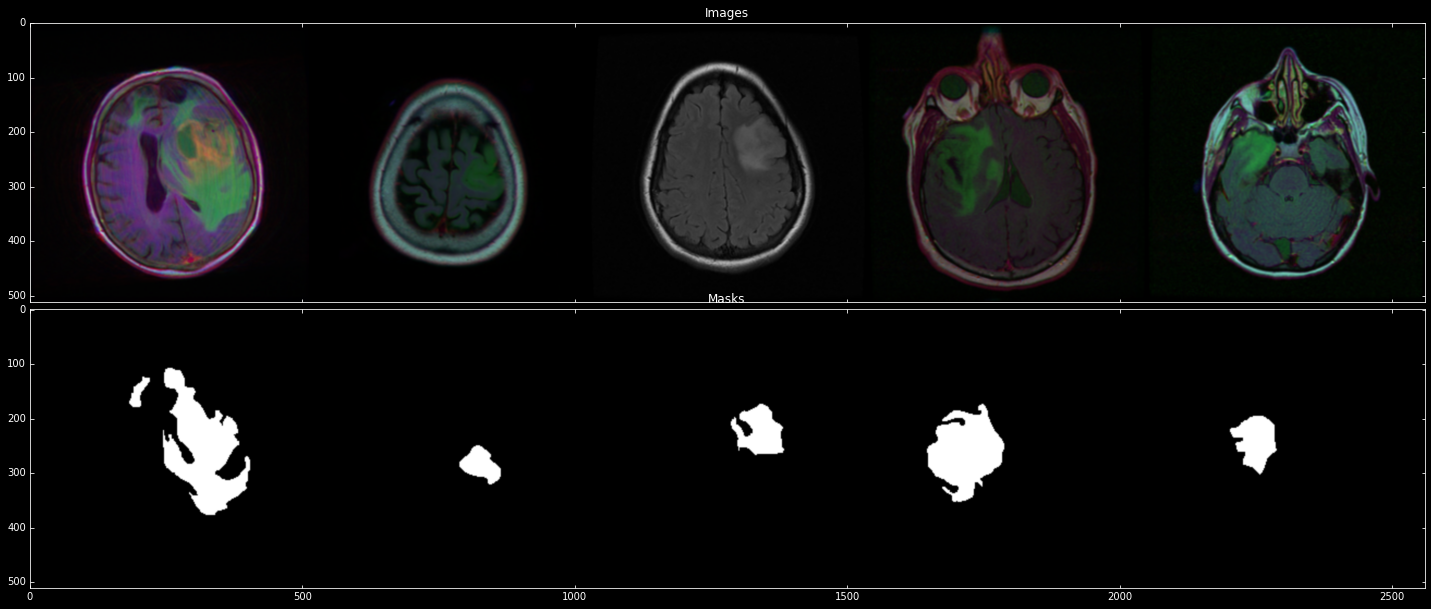

In [ ]:
#positive and masks
sample_df = df[df['diagnosis'] == 1].sample(5).values
sample_imgs = []
for i, data in enumerate(sample_df):
  img = cv2.resize(cv2.imread(data[1]),(512,512))
  mask = cv2.resize(cv2.imread(data[2]),(512,512))
  sample_imgs.extend([img,mask])

sample_imgs_arr = np.hstack(np.array(sample_imgs[::2]))
sample_masks_arr = np.hstack(np.array(sample_imgs[1::2]))

fig = plt.figure(figsize=(25,25))
grid = ImageGrid(fig, 111, nrows_ncols=(2,1),axes_pad=0.1)

grid[0].imshow(sample_imgs_arr)
grid[0].set_title("Images")
grid[0].axis("off")
grid[1].imshow(sample_masks_arr)
grid[1].set_title("Masks")
grid[1].axis("off")
plt.show()

In [ ]:
#split dataset
train_df,val_df = train_test_split(df, stratify=df.diagnosis, test_size=0.1)
train_df, test_df = train_test_split(train_df,stratify=train_df.diagnosis,test_size=0.20)
print(f'Train:{train_df.shape} \nval:{val_df.shape} \ntest:{test_df.shape}')

Train:(2828, 4) 
val:(393, 4) 
test:(708, 4)
